In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import os
from brainspace.gradient import GradientMaps
import glob

In [10]:
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0' #NOTE rsfMRI data seems to be missing!
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
tmp_dir = 'tmp_MICs-FC'

subs = glob.glob(hippunfold_dir + '/sub-HC*')
for i in range(len(subs)): subs[i] = subs[i].split('/')[-1]
for i in range(len(subs)): subs[i] = subs[i][4:]
ses = '01'
hemis = ['L','R']
labels = ['hipp','dentate'] 
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)]

In [4]:
# warp surfaces to func space then sample
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    try:
        # convert affines
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-rest_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-rest_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii')
    except:
        print(sub)
!rm -r {tmp_dir}


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -volume-to-surface-mapping /data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC098/ses-01/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-HC098_ses-01_space-func_desc-se_preproc.nii.gz tmp_MICs-FC/sub-HC098_ses-01_0_0_deform.surf.gii tmp_MICs-FC/sub-HC098_ses-01_0_0_rsfMRI.func.gii -enclosing

ERROR: NAME OF FILE: sub-HC098_ses-01_space-func_desc-se_preproc.nii.gz
PATH TO FILE: /data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/sub-HC098/ses-01/func/desc-se_task-rest_acq-AP_bold/volumetric

File does not exist.


While running:
/data/mica1/01_programs/workbench-1.4.2/bin_linux64/../exe_linux64/wb_command -metric-smoothing /data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold/sub-HC098/ses-01/surf/sub-HC098_ses-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii tmp_MICs-FC/sub-HC098_ses-01_0_0_rsfMRI.func.gii 1 tmp_MICs-FC/sub-HC098_ses-01_0_0_rsfMRI_smooth.func.gii

E

In [16]:
cdata_hipp = np.ones((483,2,695,len(subs)))*np.nan
for s,sub in enumerate(subs):
    try:
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                cdata_hipp[ind[l],h,:,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data.T[:,:695]
    except:
        print(sub)

HC098
HC113
HC061
HC006
HC104
HC117
HC114
HC109
HC062
HC021
HC111
HC110
HC107
HC071
HC103
HC070
HC116
HC004
HC051


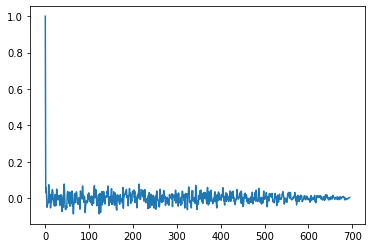

In [19]:
t = cdata_hipp[1,0,:,1]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf)

In [20]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    i = data.reshape(-1, data.shape[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = np.sum(acf[:f[0]])
    out = np.reshape(out,data.shape[:-1])*TR
    return out

/tmp/ipykernel_45696/18193459.py:14: RuntimeWarning: invalid value encountered in true_divide
  acf = acf / var / len(ndat)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


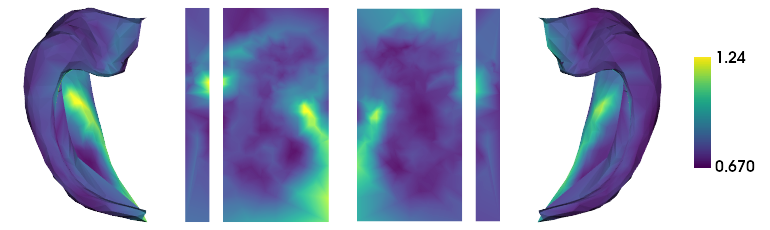

In [25]:
sub = subs[0]
TR = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-rest_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz').header.get_zooms()[-1]
InT = np.ones((483,2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    InT[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR, threshold=0)
plotting.surfplot_canonical_foldunfold(np.nanmean(InT,axis=2), den='2mm', share='row', color_bar='right', embed_nb=True)

(array([8.3257e+04, 6.7490e+03, 1.6990e+03, 6.1400e+02, 2.2800e+02,
        1.0400e+02, 5.4000e+01, 8.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([0.60000002, 1.11268791, 1.6253758 , 2.13806369, 2.65075158,
        3.16343946, 3.67612735, 4.18881524, 4.70150313, 5.21419101,
        5.7268789 ]),
 <BarContainer object of 10 artists>)

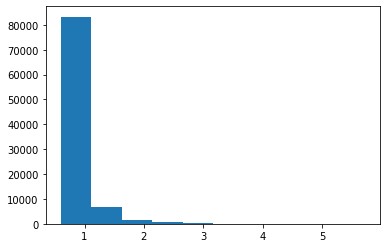

In [27]:
plt.hist(InT.flatten())

In [ ]:
# load and plot reference gradients 
HCPL_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-L.npy')
HCPR_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-R.npy')
plotting.surfplot_canonical_foldunfold(np.stack((HCPL_ref[:,:3],HCPR_ref[:,:3]),axis=1), den='2mm', size=[400,200], embed_nb=True)

In [ ]:
#run gradients for all subjects
ngrads = 10
all_grads = np.zeros((483,2,ngrads))
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')

for sub in subs:
    !mkdir -p f'{gradient_dir}/{sub}/{ses}'
    neo_cdata = np.loadtxt(f'{micapipe_dir}/{sub}/{ses}/func/desc-me_task-rest_bold/surf/{sub}_{ses}_surf-fsLR-32k_atlas-schaefer-400_desc-timeseries_clean.txt',delimiter=',')

    for h in range(len(hemi)):
        cdata_hipp = nib.load(f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-hipp_rsfMRI.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi[h]}_space-T1w_den-2mm_label-dentate_rsfMRI.func.gii').darrays[0].data
        hipp_neo_data = np.concatenate((cdata_hipp,cdata_dg), axis=0)

        if hemi[h] == 'L':
            neo_cdataL = neo_cdata[:200,:]
            FC = np.corrcoef(hipp_neo_data,neo_cdataL)

            gradientsL = gm.fit(FC[0:483,483:683], reference=HCPL_ref)
            all_grads[:,h,:] = gradientsL.aligned_
            np.savetxt(os.path.join(gradient_dir, f'{sub}/{ses}/{sub}_{ses}_hemi-{hemi[h]}_gradients.txt'), all_grads[:,h,:],delimiter=',')
        else:            
            neo_cdataR = neo_cdata[200:400,:]
            FC = np.corrcoef(hipp_neo_data,neo_cdataR)

            gradientsR = gm.fit(FC[0:483,483:683], reference=HCPR_ref)
            all_grads[:,h,:] = gradientsR.aligned_
            np.savetxt(os.path.join(gradient_dir, f'{sub}/{ses}/{sub}_{ses}_hemi-{hemi[h]}_gradients.txt'), all_grads[:,h,:],delimiter=',')

plotting.surfplot_canonical_foldunfold(all_grads[:,:3], den='2mm', size=[400,200], embed_nb=True)

In [ ]:
#plot subject specific gradients 
for sub in subs:
    gradientsL = np.loadtxt(f'{gradient_dir}/{sub}/{ses}/{sub}_{ses}_hemi-L_gradients.txt',delimiter=',')
    gradientsR = np.loadtxt(f'{gradient_dir}/{sub}/{ses}/{sub}_{ses}_hemi-R_gradients.txt',delimiter=',')
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,30), subplot_kw={'projection': "3d"})
    for f in range(3):
        plotting.surfplot_canonical_foldunfold(ax[f], np.concatenate((gradientsL[:,f],gradientsR[:,f])), den='2mm')
        ax[f].title.set_text(f'G {str(f+1)}')

In [ ]:
hipp_dat.shape